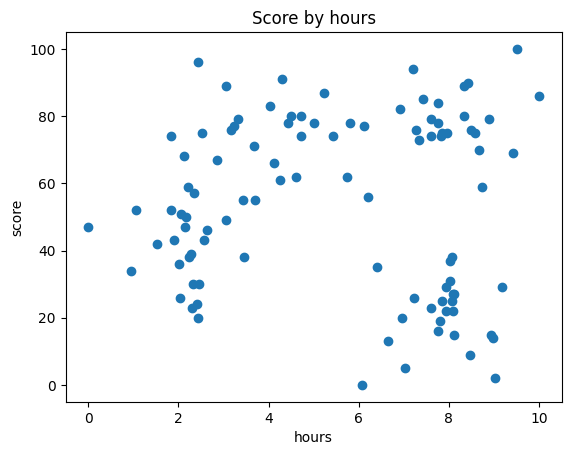

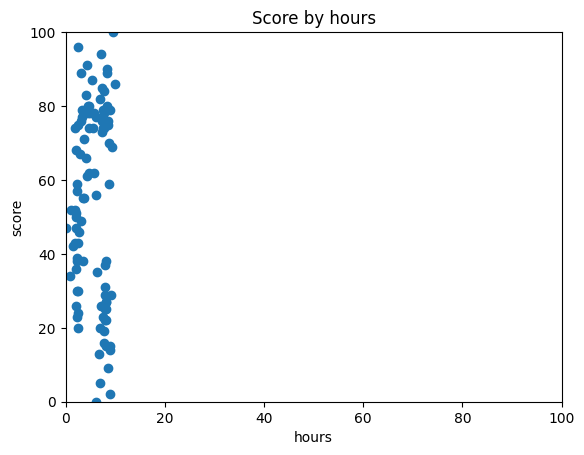

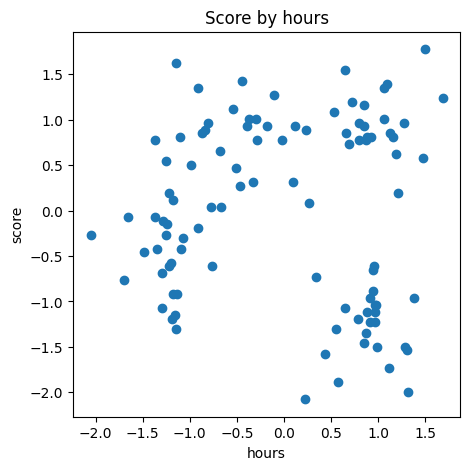

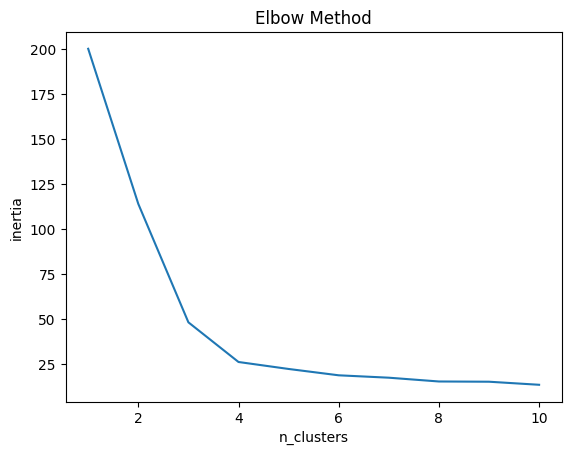

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

# 데이터 로드
dataset = pd.read_csv('../dataset/KMeansData.csv')
dataset[:5]

# X지정
X = dataset.iloc[:,:].values
X[:5]

#산점도
plt.scatter(X[:,0], X[:, 1])
plt.title('Score by hours')
plt.xlabel('hours')
plt.ylabel('score')
plt.show()

#산점도 2
plt.scatter(X[:,0], X[:, 1])
plt.title('Score by hours')
plt.xlabel('hours')
plt.xlim(0, 100)
plt.ylabel('score')
plt.ylim(0, 100)
plt.show()

# 스케일링
sc =StandardScaler()
X = sc.fit_transform(X)
X[:5]

# 산점도 3
plt.figure(figsize =(5, 5))
plt.scatter(X[:,0], X[:, 1])
plt.title('Score by hours')
plt.xlabel('hours')
plt.ylabel('score')
plt.show()

inertia_list = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(X)
    inertia_list.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia_list)
plt.title('Elbow Method')
plt.xlabel('n_clusters')
plt.ylabel('inertia')
plt.show()

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9617 - val_loss: 0.6262
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6379 - val_loss: 0.2457
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3818 - val_loss: 0.0857
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2657 - val_loss: 0.0755
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2536 - val_loss: 0.0501
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2085 - val_loss: 0.0341
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1981 - val_loss: 0.0338
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1718 - val_loss: 0.0313
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1582 - val_loss: 0.0326
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1660 - val_loss: 0.0295
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1552 - val_loss: 0.0235
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1

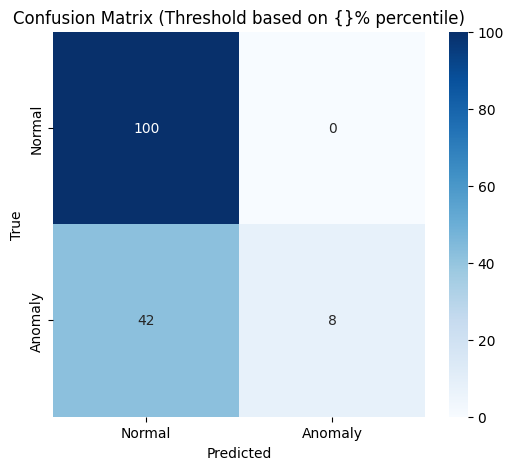

 ROC AUC Score (Threshold based on 95% percentile): 1.0000

Best Threshold (based on F1 score): 0.2945
Best F1 Score: 0.5000

 Classification Report (Optimized Threshold based on F1 Score):
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00       100
     Anomaly       1.00      0.98      0.99        50

    accuracy                           0.99       150
   macro avg       1.00      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

 Confusion Matrix (Optimized Threshold based on F1 Score):


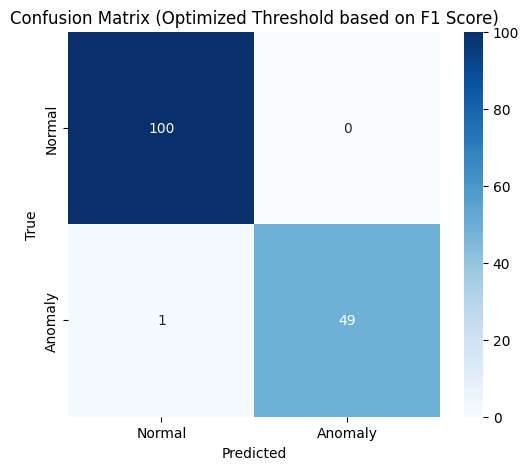

 ROC AUC Score (Optimized Threshold): 1.0000


In [6]:
# 온도, 압력, 진동 센서 데이터를 활용한 비지도 학습 기반 이상 탐지 (오토인코더 기반)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # Matplotlib에서 3차원 플롯을 그릴 수 있도록 지원하는 도구

# 1. 데이터 불러오기
try: 
    df_train = pd.read_csv("../dataset/train_data.csv")
    df_test = pd.read_csv("../dataset/test_data.csv")
except FileNotFoundError:
    print("경로에 파일이 없습니다")
    exit()
    
#2. 데이터 전처리
if  df_train.isnull().sum().any() or df_test.isnull().sum().any():  # any() 결측치가 있으면 True, False로 반환
    print("경고: 결측치가 감지되었습니다. 평균값으로 채웁니다.")
    df_train.fillna(df_train.mean(), inplace=True)
    df_test.fillna(df_test.mean(), inplace=True)
    
# 피처 선택 
X_train = df_train[["temperature", "pressure", "vibration"]].values
X_test = df_test[["temperature", "pressure", "vibration"]].values
y_test = df_test["label"].values # 0 = 정상, 1 = 불량

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# "오토인코더" 모델 정의
def build_autoencoder(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        #인코더
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='relu'),
        #디코더
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(input_dim, activation=None)
        
        
    ])
    return model

# 모델 생성 및 컴파일 
autoencoder = build_autoencoder(input_dim=3)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), loss='mse')

# 얼리종료 콜백
EarlyStopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

#모델 학습
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    callbacks=[EarlyStopping],
    verbose=1
)  

# 테스트셋에 대한 재구성 오차계산
X_test_pred = autoencoder.predict(X_test_scaled, verbose=0)
mse = np.mean(np.square(X_test_scaled - X_test_pred), axis=1)

# 7. 임계값 설정 (기존 : 95% 백분위)
threshold_percentile = 95
threshold = np.percentile(mse, threshold_percentile)
print(f"Threshold ({threshold_percentile}% percentile): {threshold:.4f}")


# 이상 탐지 결과 
y_pred = (mse > threshold).astype(int)

# 평가 (기존 임계값)
print("\n Classification Report (Threshold based on {}% percentile):".format(threshold_percentile))
print(classification_report(y_test, y_pred, target_names=["Normal", "Anomaly"]))  # Normal(정상), Anomaly(불량)

print(" Confusion Matrix (Threshold based on {}% percentile):".format(threshold_percentile))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix (Threshold based on {}% percentile)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

sc = roc_auc_score(y_test, mse)
print(f" ROC AUC Score (Threshold based on {threshold_percentile}% percentile): {sc:.4f}")


# 최적 임계값으로 찾기
precision, recalls, thresholds_pr = precision_recall_curve(y_test, mse)
f1_scores = 2 * recalls * precision / (recalls + precision) /(recalls + precision + 1e-8)
best_threshold_idx = np.argmax(f1_scores) # f1_scores 배열에서 가장 큰 값의 인덱스를 찾아냄
best_threshold = thresholds_pr[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]


print(f"\nBest Threshold (based on F1 score): {best_threshold:.4f}")
print(f"Best F1 Score: {best_f1:.4f}")

# 최적 임계값으로 예측
y_pred_optimized = (mse > best_threshold).astype(int)
print("\n Classification Report (Optimized Threshold based on F1 Score):")
print(classification_report(y_test, y_pred_optimized, target_names=["Normal", "Anomaly"]))

print(" Confusion Matrix (Optimized Threshold based on F1 Score):")
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix (Optimized Threshold based on F1 Score)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

roc_auc_optimized = roc_auc_score(y_test, mse) # MSE 기반 ROC AUC는 임계값 변경에 영향 없음
print(f" ROC AUC Score (Optimized Threshold): {roc_auc_optimized:.4f}")